# Quick Draw Neural Network

The [Quick Draw Dataset](https://quickdraw.withgoogle.com/data) is a collection of 50 million drawings across 345 categories, contributed by players of the game Quick, Draw!. The drawings were captured as timestamped vectors, tagged with metadata including what the player was asked to draw and in which country the player was located.

In this notebook I attempt to create a Deep Learning Neural Network to classify the drawings.

After building the model I'll also develop a Web API to implement this into [safoan.me](https://www.safoan.me).

## Data Processing
For this project I will make use of the `.npy` Numpy Bitmaps which on top of the simplification:
1. Align the drawing to the top-left corner, to have minimum values of 0.
2. Uniformly scale the drawing, to have a maximum value of 255.
3. Resample all strokes with a 1 pixel spacing.
4. Simplify all strokes using the Ramer–Douglas–Peucker algorithm with an epsilon value of 2.0.

Have also been redered in 28x28 gray scale images into numpy `.npy` format, while also being re-aligned to the center of the drawing bounding box. Due to this being pre-processed it makes it easier to work with.

**Metric** used will be **Accuracy** as the primary goal is to correctly guess as many as possible.

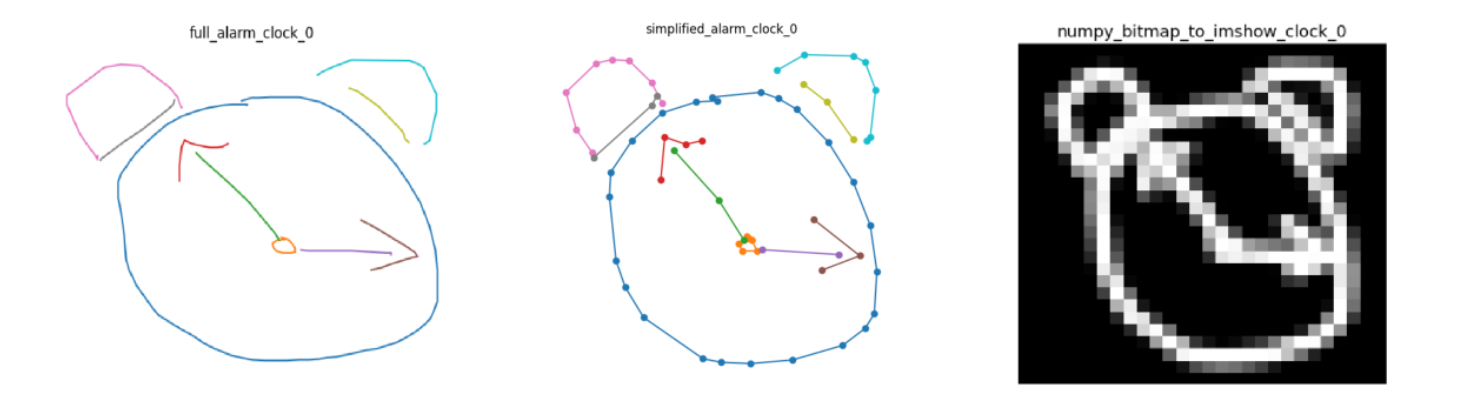

**Install the numpy bitmap "images"**
```bash
    mkdir numpy_bitmap
    gsutil -m cp "gs://quickdraw_dataset/full/numpy_bitmap/*.npy" numpy_bitmap
```

In [214]:

import os
import pandas as pd
import numpy as np
import random
from warnings import filterwarnings

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import rotate

import torch
from torch import nn
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

In [ ]:
# temp for session state saving
import dill
filename = 'globalsave.pkl'

# dill.dump_session(filename)
# dill.load_session(filename)

In [215]:
# Setup

# plots style
sns.set_theme("notebook", "whitegrid")
sns.set_palette("pastel")

# filter warnings
filterwarnings("ignore")

# set seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

For I notice the file names arent standardised, some with capitals, some with spaces so ill begin with that.

Then for runtimes for now I'll only work with 10 categories, as opposed to the total 345. This reduces the data from 50,000,000+ bitmaps.

In [2]:
IMAGES_DIR = "numpy_bitmap/"

# standardize filenames
# for filename in os.listdir(IMAGES_DIR):
#     os.rename(IMAGES_DIR + filename, IMAGES_DIR + filename.replace(" ", "_").lower())

cat_a = os.listdir(IMAGES_DIR)
print(f'Total categories: {len(cat_a)}')

cat_s = cat_a[12:22]
print(f'Sample categories: {cat_s}')

Total categories: 345
Sample categories: ['dog.npy', 'axe.npy', 'bat.npy', 'alarm_clock.npy', 'backpack.npy', 'blueberry.npy', 'elephant.npy', 'broom.npy', 'cruise_ship.npy', 'beard.npy']


In [3]:
# add all drawings into a dataframe
bmap_split = pd.DataFrame()
bmap = pd.DataFrame()
bitmaps = []

for category in cat_s:
    data = pd.DataFrame(np.load(IMAGES_DIR + category))
    data["category"] = category
    bitmaps.append(data)
    
bmap_split = pd.concat(bitmaps, ignore_index=True)
bmap_split.sample(3)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,category
804455,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,elephant.npy
1205562,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,beard.npy
1160917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,beard.npy


In [4]:
bmap["labels"] = bmap_split["category"].apply(lambda x: x.split(".")[0])
bmap["features"] = bmap_split.iloc[:, :-1].apply(lambda x: np.array(x).reshape(28,28), axis=1)

### Visualizations
Using `matplotlib`

In [5]:
def show_images(df, n_images, category=None):
    
    '''
    Converting n_images of bitmap arrays into images
    
    parameters:
    df: dataframe with features and labels columns, 
        labels: bitmap array
        features: category label
    n_images: number of images to display
    
    output: figure with n_images labelled
    return: none
    '''
    fig_h = 1.5 * (n_images//10) # height of the figure
    fig, axs = plt.subplots(n_images//10, 10, figsize=(12, fig_h))
    axs = axs.flatten() # 2D - 1D to make it simpler to iterate trough, eg: ax[0,0] -> ax[0]
    
    if not category:
        sample = df.sample(n_images)
    else:
        sample = df[df['labels'] == category].sample(n_images)
    
    label = sample['labels'].values
    image = sample['features'].values
    
    for n in range(n_images):
        axs[n].imshow(image[n])
        axs[n].set_title(label[n])
        axs[n].axis('off')
    
    plt.tight_layout()
    plt.show()

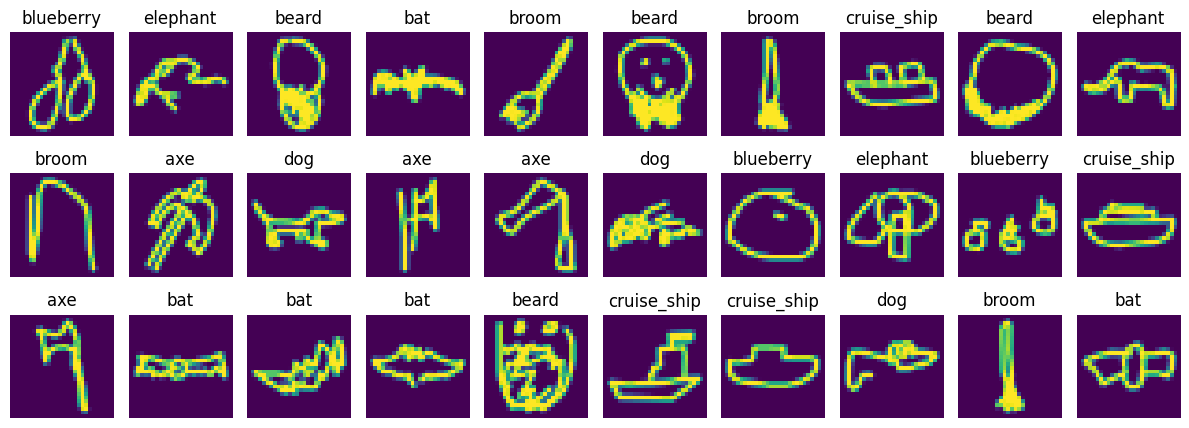

In [6]:
show_images(bmap, 30)

It'll also be interesting seeing images from each category overlayed on top of eachother as a heatmap, this will give a general understanding of the way people interpret cetain objects as some may interpret some objects to have multiple meanings.
* Ex: bat -> baseball bat, animal bat, cricket bat, etc.


Or some may also draw the same objects differently
* Ex: Orientations, style

To achieve this, I'll stack each image on top of each other then squeeze back into 2D

In [7]:
def category_heatmap(df, rows=1):
    '''
    Overlaying bitmaps of different category to create a heatmap
    
    parameters: 
    df: dataframe with features and labels columns
    rows: number of rows, must be a factor of categories
    
    output: categorical heatmaps
    returns: none
    '''
    
    categories = df['labels'].unique()
    n_cat = len(categories)
    
    n = bmap['labels'].nunique()
    
    fig, axs = plt.subplots(rows, n//rows, figsize=(12, (rows*2.5)))
    axs = axs.flatten()
    
    for n in range(n_cat):
        arrs = df[df['labels'] == categories[n]]['features']
        heatmap = np.stack(arrs).sum(axis=0)
      
        axs[n].imshow(heatmap)
        axs[n].set_title(categories[n])
        axs[n].axis('off')
        
    plt.suptitle('Categorical Heatmaps')
    plt.show()

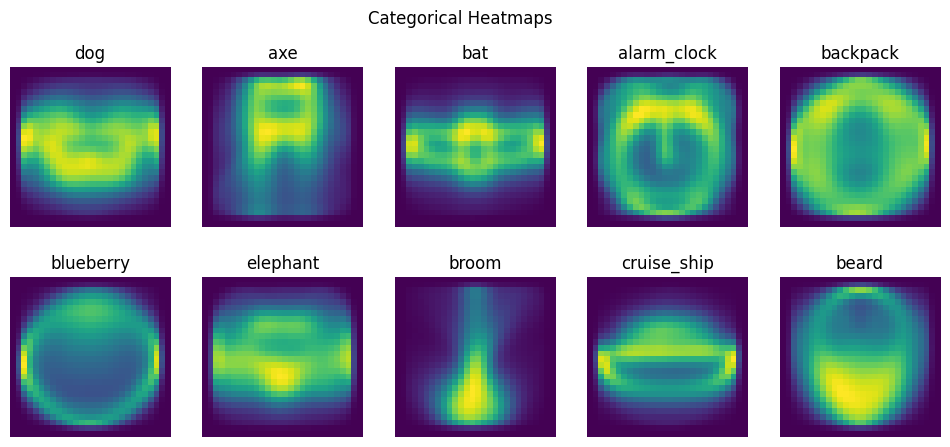

In [8]:
category_heatmap(bmap, rows=2)

A few examples of things that we can infer about the people who partook in making the drawings.
* Bat is mostly interpreted as the animal
* Broom is mostly drawn as being upright
* Alarm clock is mostly interpreted as an analog one

### Aurgmenting dataset
Add sensible variation by "generating" more images based on the images already present
* Rotating: +-15 deg [scipy.ndimage rotate]
* Flipping: horizontal and vertical

*Ill first  train the model without the extra argmented data, then with it to assess if it makes a difference*

This improves **generalization** while reducing **overfitting** and **variation**.

Depending on the representation of each category i might decide to further aurgment specific categories

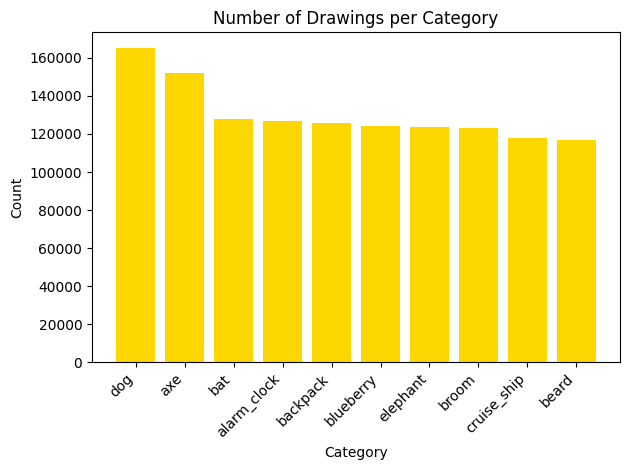

In [9]:
plt.bar(bmap['labels'].unique(), bmap['labels'].value_counts(), color='gold')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Number of Drawings per Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

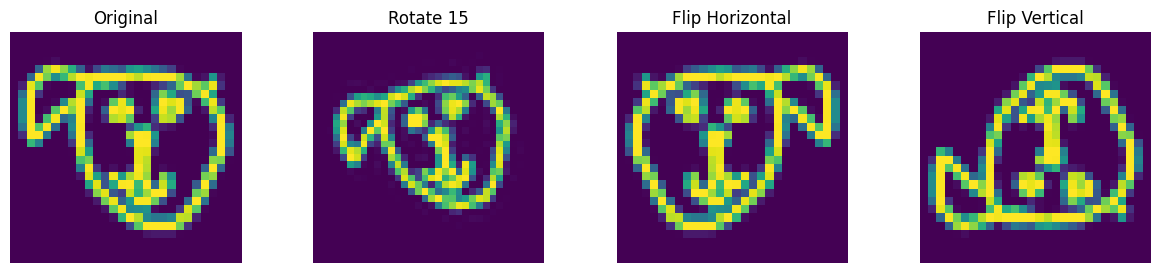

In [10]:
# emaple
fig, axs = plt.subplots(1, 4, figsize=(15, 3))
[ax.axis('off') for ax in axs]
image = bmap.iloc[0, 1]

axs[0].imshow(image)
axs[0].set_title('Original')

axs[1].imshow(rotate(image, 15, reshape=False)) # keep 28x28 shape
axs[1].set_title('Rotate 15')

axs[2].imshow(image[:,::-1])
axs[2].set_title('Flip Horizontal')

axs[3].imshow(image[::-1,:])
axs[3].set_title('Flip Vertical')

plt.show()

In [11]:
bmap_hflip = bmap.copy()
bmap_hflip['features'] = bmap_hflip['features'].apply(lambda x: x[:, ::-1])
bmap_15rot = bmap.copy()
bmap_15rot['features'] = bmap_15rot['features'].apply(lambda x: rotate(x, 15, reshape=False))

bmap_xl = pd.concat([bmap, bmap_hflip, bmap_15rot], axis=0).reset_index(drop=True)

## Convolutional Neural Network Implementation

The objective is to create a deep learning neural network which:
* **Input**:28x28 image input 
* **Return** probability of the drawing being each class

$$\text{CNN Output Size} = \frac{\text{Input} + 2 \cdot \text{Padding} - \text{Kernel}}{\text{Stride}} + 1$$


I'll begin with implementing a simple CNN with the following layers -> Output:
| **Layer Type**   | **Parameters**              | **Output Dimensions**        |
|-------------------|-----------------------------|------------------------     |
| **Input**         | 28x28 grayscale image         | 28x28x1                   |
| **Conv + ReLU**   | 16 filters, 5x5 kernel, 1 pad | 28x28x16                  |
| **MaxPooling**    | 2x2 pooling                   | 14x14x16                  |
| **Conv + ReLU**   | 32 filters, 5x5 kernel        | 14x14x32                  |
| **MaxPooling**    | 2x2 pooling                   | 7x7x32                    |
| **Flatten**       | Convert to 1D                 | 1568                      |
| **Dense**         | 10 neurons                    | 10 (class probabilities)  |


### Preparing Data
Turn dataset value into tensors

Split into batches, for computational efficiency: `batch_size`: 64.

`train`, `test`, `validation`: 80/10/10

In [12]:
def df_to_tensors(df, X='features', y='labels'):
    '''
    Converting dataframe tensor friendly format
    
    parameters:
    df: dataframe with features and labels columns
    
    return: features and labels as tensors
    '''
    
    unique = df[y].unique()
    labels_map = {}
    
    for n, cat in enumerate(unique):
        labels_map[cat] = n # mapping category to integer, eg: alarm_clock -> 0, shoe -> 1
        
    df[y] = df[y].map(labels_map)
    
    features = torch.tensor([x for x in df[X]])
    labels = torch.tensor([x for x in df[y]])
    
    features = features.float() / 255.0 # normalizing 0-255 -> 0-1
    features = features.unsqueeze(1) # adding channel dimension for CNN
    
    return features, labels, labels_map

In [13]:
features, labels, labels_map = df_to_tensors(bmap.copy())
bmap_tensors = list(zip(features, labels))

C:\Users\safho\AppData\Local\Temp\ipykernel_28328\859970199.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  features = torch.tensor([x for x in df[X]])


In [22]:
train_data, test_data = train_test_split(bmap_tensors, test_size=0.2, random_state=0)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=0)

print(f'Train: {len(train_data)}, Test: {len(test_data)}, Validation: {len(val_data)}')

Train: 1043184, Test: 130398, Validation: 130399


In [23]:
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

### Base Model Building
Convolutional Neural Network with the layers mantioned before. Ill split in into 2 sets:
* Conv1
* Conv2
* Fully Connected

In [24]:
class QuickDrawCNN_V1(nn.Module):
    def __init__(self, input_shape=(1, 28, 28), n_classes=10):
        super().__init__()
        
        self.conv_set_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=5, padding=2), # padding = (kernel_size - 1) / 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )   
        
        self.conv_set_2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # fully connected layer
        self.dense = nn.Sequential( 
            nn.Flatten(), # 2D -> 1D
            nn.Linear(32 * 7 * 7, n_classes),
            #nn.Softmax(dim=1) # CrossEntropyLoss() already has softmax
        )
        
        self.stack = nn.Sequential(
            self.conv_set_1,
            self.conv_set_2,
            self.dense
        )
        
    def forward(self, x):
        return self.stack(x)

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

Using cuda


In [26]:
model_1 = QuickDrawCNN_V1().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

In [27]:
def calc_accuracy(y_pred, y_true):
    y_pred = y_pred.argmax(dim=1)  # Fing the index of the max value, prediction
    correct = torch.eq(y_true, y_pred).sum().item() # Compare prediction with true label, get value
    acc = (correct / len(y_pred)) * 100
    
    return acc

In [28]:
def train(model, train_loader, val_loader, epochs, criterion, optimizer, device):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    
    for epoch in range(epochs):
        
        epoch_train_loss, epoch_train_acc = 0, 0
        size = len(train_loader)
        
        # Train
        for image, label in train_loader:
            model.train()
            
            image, label = image.to(device), label.to(device) # move data to device
            
            y_logits = model(image) # forward pass
            
            # calculate loss, acc
            loss = criterion(y_logits, label)
            acc = calc_accuracy(y_logits, label)
            
            optimizer.zero_grad() # zero grad
            loss.backward() # backward pass, prep for backpass
            optimizer.step() # update weights
            
            epoch_train_loss += loss.item()
            epoch_train_acc += acc
        
        train_loss.append(epoch_train_loss / size)
        train_acc.append(epoch_train_acc / size)
        
        # Validation
        model.eval()
        epoch_train_loss, epoch_train_acc = 0, 0
        size = len(val_loader)
        
        with torch.inference_mode():
            for image, label in val_loader:
                image, label = image.to(device), label.to(device)
                y_logits = model(image)
                loss = criterion(y_logits, label)
                acc = calc_accuracy(y_logits, label)
                
                epoch_train_loss += loss.item()
                epoch_train_acc += acc
                
        val_loss.append(epoch_train_loss / size)
        val_acc.append(epoch_train_acc / size)
        
        print(f'Epoch: {epoch+1} | Val Loss {val_loss[-1]:.5f} | Val Acc {val_acc[-1]:.2f}%') # [-1] last element
        
    return train_loss, val_loss, train_acc, val_acc


In [29]:
train_loss_1, val_loss_1, train_acc_1, val_acc_1 = train(
    model=model_1,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=10,  
    criterion=criterion,
    optimizer=optimizer,
    device=device
)

Epoch: 1 | Val Loss 0.36494 | Val Acc 88.68%
Epoch: 2 | Val Loss 0.34484 | Val Acc 89.38%
Epoch: 3 | Val Loss 0.34113 | Val Acc 89.40%
Epoch: 4 | Val Loss 0.33251 | Val Acc 89.67%
Epoch: 5 | Val Loss 0.32994 | Val Acc 89.87%
Epoch: 6 | Val Loss 0.32759 | Val Acc 89.89%


In [31]:
def plot_metrics(title,
                 metric1_set1, metric2_set1, metric1_set2, metric2_set2, 
                 metric1_label='Train', metric2_label='Validation', 
                 set1_label='Loss', set2_label='Accuracy'):
    
    '''
    Plotting training and validation metrics using matplotlib
    
    parameters:
    metrics_set1, metrics_set2: 2 metrics to show in same plot
    
    output: 2 subplots
    '''
    
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))

    axs[0].plot(metric1_set1, label=metric1_label)
    axs[0].plot(metric2_set1, label=metric2_label)
    axs[0].set_title(set1_label)
    axs[0].legend()

    axs[1].plot(metric1_set2, label=metric1_label)
    axs[1].plot(metric2_set2, label=metric2_label)
    axs[1].set_title(set2_label)
    axs[1].legend()
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

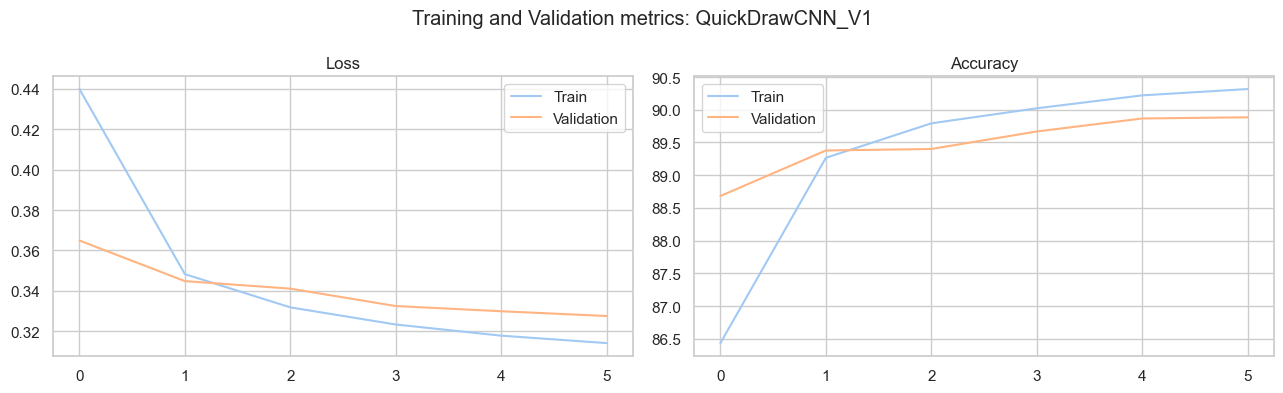

In [32]:
plot_metrics(f'Training and Validation metrics: {model_1._get_name()}',train_loss_1, val_loss_1, train_acc_1, val_acc_1)

The model seems to already be performing well, with an accuracy of around ~ 90% on only 5 epochs and the simple CNN structure.

Lets take a look at the model prediction with images

In [33]:
def get_dict_key(dictionary, value):
    for k, v in dictionary.items():
        if v == value:
            return k

In [225]:
# manual view on
def test_pred(n, model, loader, label_map, visualize=False, rows=1, notice=False):
    '''
    Predict the catetory of n images using a trained model and visualize if need be
    
    parameters:
    n: number of images to predict
    model: trained model
    loader: data loader
    map: labels mapping
    visualize: display images or not
    rows: number of rows in the plot, must be a factor of n
    notice: print the notice/warning
    
    output: image with label
    return: dataframe with incorrect predictions and % correct
    
    '''
    
    predictions = {'image': [], 'true': [], 'pred': [], 'correct': []}
    
    for _ in range(n):
        feature, label = next(iter(loader)) # data unseen by model
        idx = random.randint(0, len(feature)-1) # random index from batch
        image_arr = feature[idx]
        label = get_dict_key(label_map, label[idx].item())

        with torch.inference_mode():
            # forward pass, adding batch dimension in front -> (1, 1, 28, 28)
            logits = model(image_arr.to(device).unsqueeze(0))

        pred = logits.argmax(dim=1).item()
        pred = get_dict_key(label_map, pred)

        predictions['image'].append(image_arr)
        predictions['true'].append(label)
        predictions['pred'].append(pred)
        predictions['correct'].append(label == pred)
    
    # correct predictions %
    correct_p = round((sum(predictions['correct']) / n) * 100, 2)
    
    # remove batch dimension, and convert tensors to numpy
    predictions['image'] = [img_tensor.squeeze(0).numpy() for img_tensor in predictions['image']]
    
    # visualize
    if visualize:
        fig, axs = plt.subplots(rows, n//rows, figsize=(14, (rows*2.1)))
        axs = axs.flatten()
        [ax.axis('off') for ax in axs]
        
        for n in range(n):
            axs[n].imshow(predictions['image'][n])
            axs[n].set_title(f'{predictions["true"][n]} | {predictions["pred"][n]}', fontsize=8)
        
        plt.tight_layout()
        plt.suptitle(f'True | Predictions | {correct_p}%', fontsize=15)
        plt.show()
        
    else:
        incorrect_preds = {'image': [], 'true': [], 'pred': [], 'correct': []}
        for i in range(len(predictions['correct'])):
            if not predictions['correct'][i]:
                incorrect_preds['image'].append(predictions['image'][i])
                incorrect_preds['true'].append(predictions['true'][i])
                incorrect_preds['pred'].append(predictions['pred'][i])
                incorrect_preds['correct'].append(predictions['correct'][i])
        
        return pd.DataFrame(incorrect_preds), correct_p
        
    print("NOTE: The % correctness is based on a small random validation sample, it does not represent the model's accuracy !!!!")

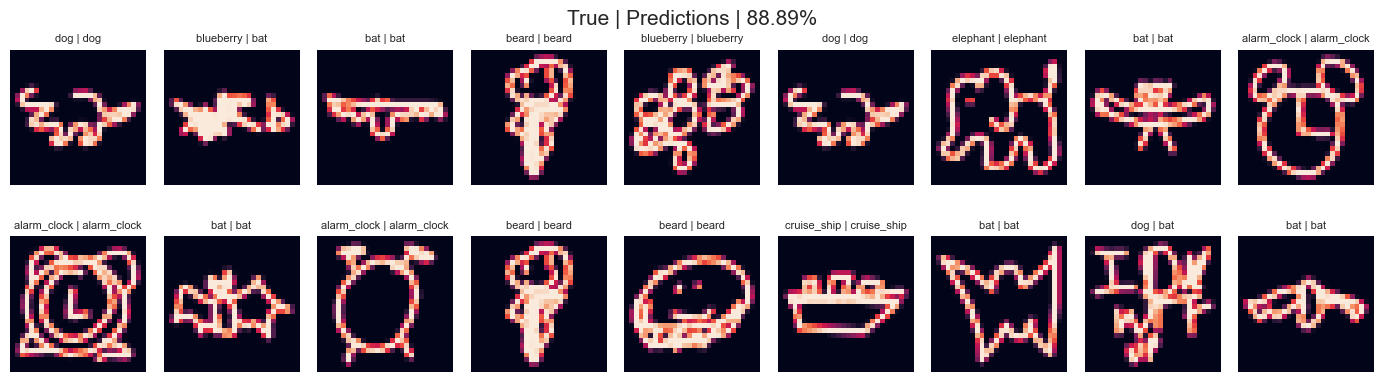

NOTE: The % correctness is based on a small random validation sample, it does not represent the model's accuracy !!!!


In [162]:
test_pred(n=18, 
             model=model_1, 
             loader=val_loader,
             label_map=labels_map,
             visualize=True,
             rows=2)

### More Complex Model
The current architechture performs well, however the accuracy seems to max aout at about 89-90% for validation. A more complex architechture additional layers and a dropout for regulation will increase the models capacity to learn more complex features.

1. Batch Normalization in Conv sets:
    * Normalize the activations at each layer, will allow for higher learning rate, it also helps reducing covariance shift (residual shift)
2. Extra Convolutional layer:
    * Conv1: Basic edge and shaped
    * Conv2: Futher patterms and combination of edges
    * Conv3: Detects higher level features, more object specific characteristics (higher filter, lower kernels)
    * 16 -> 32 -> 64: makes the Network capture progressivley more complex patterns
    * 5x5 -> 5x5 -> 3x3: Final layer looks at more fine details
3. Extra Dense Layer (256):
    * Acts as a bottleneck, keeping the most important features
    * Intermidiary for the next Dense(10) layer, which might have caused some underfitting
4. Dropout (0.3)
    * Prevents overfitting by randomly disabling neurons
    * Makes sure that the model doesnt overly rely on spcific patterns


| **Layer Type**       | **Parameters**                    | **Output Dimensions**   |
|-----------------------|------------------------------------|--------------------------|
| **Input**                     | 28x28 grayscale image                 | 28x28x1                 |
| **Conv + BatchNorm + ReLU**   | 16 filters, 5x5 kernel, no padding    | 28x28x16                |
| **MaxPooling**                | 2x2 pooling                           | 14x14x16                |
| **Conv + BatchNorm + ReLU**   | 32 filters, 5x5 kernel, no padding    | 14x14x32                |
| **MaxPooling**                | 2x2 pooling                           | 7x7x32                  |
| **Conv + BatchNorm + ReLU**   | 64 filters, 3x3 kernel, no padding    | 4x4x64                  |
| **MaxPooling**                | 2x2 pooling                           | 3x3x64                  |
| **Flatten**                   | Convert to 1D                         | 576                     |
| **Dense + ReLU**              | 256 neurons                           | 256                     |
| **Dropout**                   | 0.3 dropout rate                      | 256                     |
| **Dense**                     | 10 neurons                            | 10 (class probabilities)|


In [36]:
class QuickDrawCNN_V2(nn.Module):
    def __init__(self, input_shape=(1, 28, 28), n_classes=10):
        super().__init__()
        
        self.conv_set_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )   
        
        self.conv_set_2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_set_3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.flatten = nn.Flatten()

        # fully connected layer
        self.dense_set_1 = nn.Sequential( 
            nn.Linear(64 * 3 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        self.dense_set_2 = nn.Sequential( 
            nn.Linear(256, n_classes),
        )
        
        self.stack = nn.Sequential(
            self.conv_set_1,
            self.conv_set_2,
            self.conv_set_3,
            self.flatten,
            self.dense_set_1,
            self.dense_set_2
        )
        
    def forward(self, x):
        return self.stack(x)

In [37]:
# reinitialize model with new architecture, criterion and optimizer
model_2 = QuickDrawCNN_V2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

In [38]:
train_loss_2, val_loss_2, train_acc_2, val_acc_2 = train(
    model=model_2,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=10,
    criterion=criterion,
    optimizer=optimizer,
    device=device
)

Epoch: 1 | Val Loss 0.29457 | Val Acc 90.52%
Epoch: 2 | Val Loss 0.26528 | Val Acc 91.61%
Epoch: 3 | Val Loss 0.26350 | Val Acc 91.65%
Epoch: 4 | Val Loss 0.25436 | Val Acc 91.94%
Epoch: 5 | Val Loss 0.24321 | Val Acc 92.35%
Epoch: 6 | Val Loss 0.23927 | Val Acc 92.43%


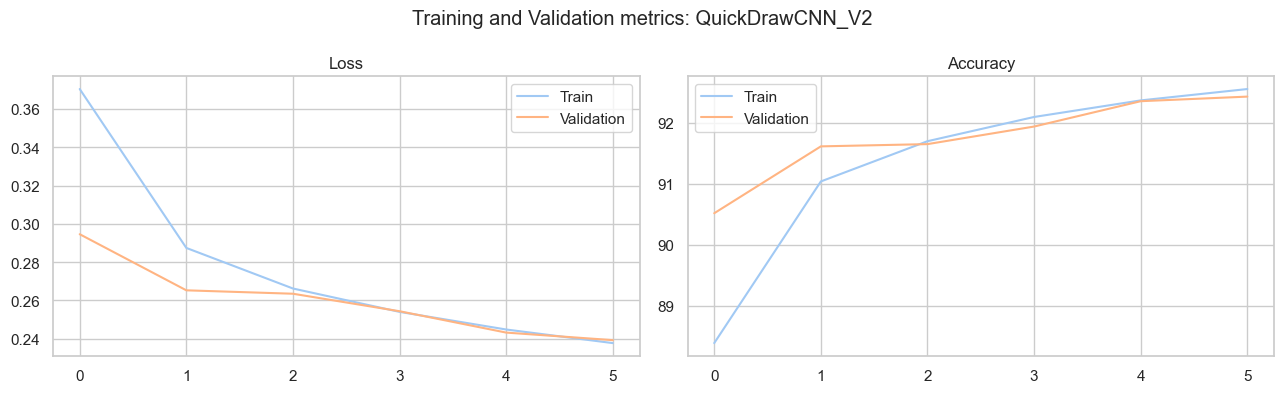

In [39]:
plot_metrics(f'Training and Validation metrics: {model_2._get_name()}',train_loss_2, val_loss_2, train_acc_2, val_acc_2)

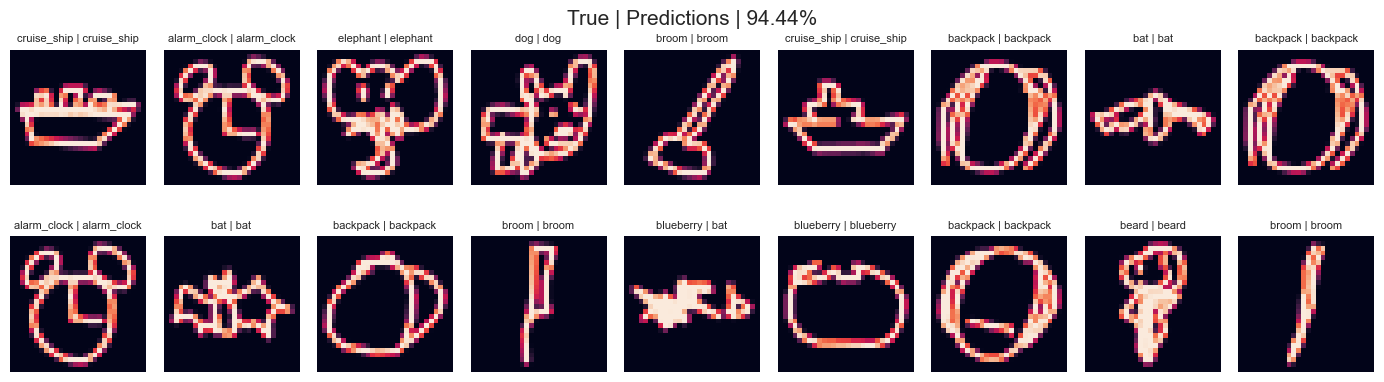

NOTE: The % correctness is based on a small random validation sample, it does not represent the model's accuracy !!!!


In [185]:
test_pred(n=18, 
             model=model_2, 
             loader=val_loader,
             label_map=labels_map,
             visualize=True,
             rows=2)

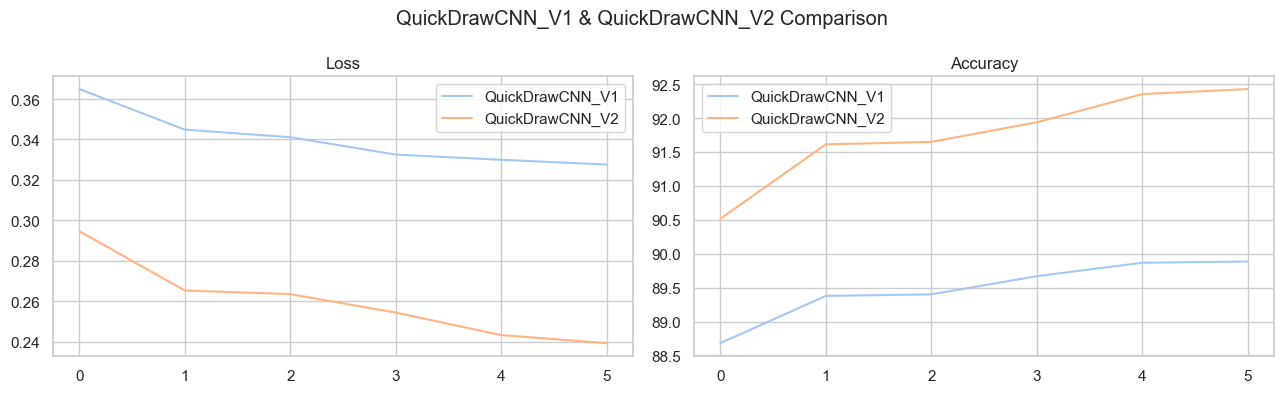

In [41]:
plot_metrics(f'{model_1._get_name()} & {model_2._get_name()} Validation Comparison', val_loss_1, val_loss_2, val_acc_1, val_acc_2,
             metric1_label=model_1._get_name(), metric2_label=model_2._get_name(),
             set1_label='Loss', set2_label='Accuracy')

The V2 model achieved a significant improvement, reaching **~92.5%** accuracy compared to **~89.8%** from the V1 model. This improvement can be attributed to the inclusion of additional layers, batch normalization, and dropout, which helped the model generalize better while preventing overfitting.

I'll now use the augmented dataset `bmap_xl` (including rotated and flipped images) for training to evaluate whether the model benefits from increased diversity in data or not.

In [56]:
features_xl, labels_xl, labels_map_xl = df_to_tensors(bmap_xl.copy())
bmap_xl_tensors = list(zip(features_xl, labels_xl))

train_data_xl, test_data_xl = train_test_split(bmap_xl_tensors, test_size=0.2, random_state=0)
test_data_xl, val_data_xl = train_test_split(test_data_xl, test_size=0.5, random_state=0)

train_loader_xl = DataLoader(train_data_xl, batch_size=batch_size, shuffle=True)
test_loader_xl = DataLoader(test_data_xl, batch_size=batch_size, shuffle=False)
val_loader_xl = DataLoader(val_data_xl, batch_size=batch_size, shuffle=False)

model_3 = QuickDrawCNN_V2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

In [58]:
train_loss_3, val_loss_3, train_acc_3, val_acc_3 = train(
    model=model_3,
    train_loader=train_loader_xl,
    val_loader=val_loader_xl,
    epochs=10,
    criterion=criterion,
    optimizer=optimizer,
    device=device
)

Epoch: 1 | Val Loss 0.22604 | Val Acc 92.94%
Epoch: 2 | Val Loss 0.22431 | Val Acc 92.93%
Epoch: 3 | Val Loss 0.22656 | Val Acc 92.89%
Epoch: 4 | Val Loss 0.22486 | Val Acc 92.95%
Epoch: 5 | Val Loss 0.22444 | Val Acc 92.94%
Epoch: 6 | Val Loss 0.22751 | Val Acc 92.86%
Epoch: 7 | Val Loss 0.22392 | Val Acc 92.98%
Epoch: 8 | Val Loss 0.22132 | Val Acc 93.05%
Epoch: 9 | Val Loss 0.22383 | Val Acc 92.97%
Epoch: 10 | Val Loss 0.22072 | Val Acc 93.08%


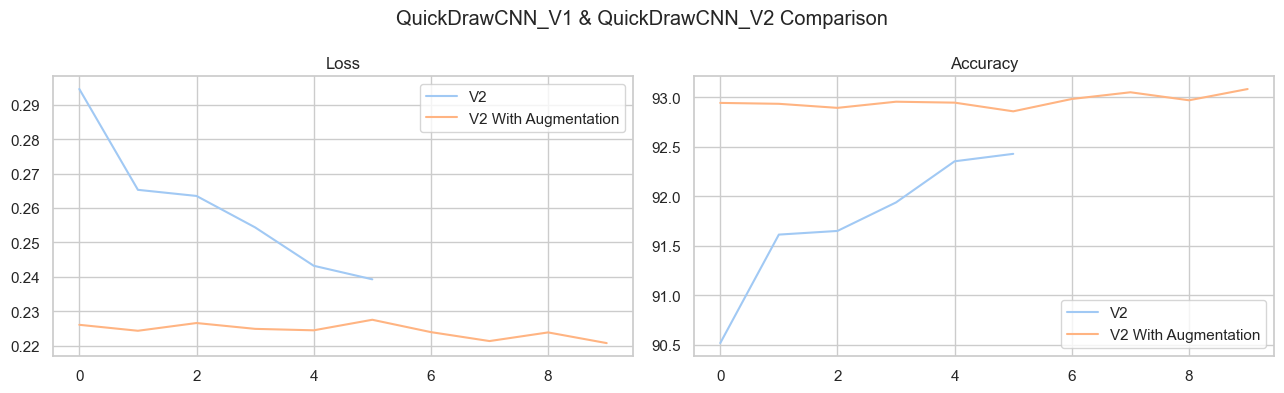

In [60]:
plot_metrics(f'{model_1._get_name()} & {model_2._get_name()} Comparison', val_loss_2, val_loss_3, val_acc_2, val_acc_3,
             metric1_label='V2', metric2_label='V2 With Augmentation',
             set1_label='Loss', set2_label='Accuracy')

## Model Train Conclusion

In [226]:
results = []

models_to_test = [
    {"model": model_1, "loader": test_loader, "label_map": labels_map, "name": model_1._get_name(), 'val_accuracy': val_acc_1[-1]}, #grab last accuracy
    {"model": model_2, "loader": test_loader, "label_map": labels_map, "name": model_2._get_name(), 'val_accuracy': val_acc_2[-1]},
    {"model": model_3, "loader": test_loader_xl, "label_map": labels_map_xl, "name": model_3._get_name(), 'val_accuracy': val_acc_3[-1]}
]

# going trough each model then testing
for item in models_to_test:
    incorrects, correct = test_pred(
        n=len(item["loader"]),
        model=item["model"],
        loader=item["loader"],
        label_map=item["label_map"],
        visualize=False,
        rows=2
    )
    
    # testing on unseen data by the model and me.
    results.append({
        "model": item["name"],
        "true_accuracy": correct,
        "val_accuracy": round(item["val_accuracy"], 2),
        "total": len(item["loader"]),
        "correct": len(item["loader"]) - len(incorrects),
        "incorrect": len(incorrects)
    })

# convert to df
test_eval = pd.DataFrame(results)
print(test_eval)

             model  true_accuracy  val_accuracy  total  correct  incorrect
0  QuickDrawCNN_V1          86.90         89.89   2038     1771        267
1  QuickDrawCNN_V2          87.34         92.43   2038     1780        258
2  QuickDrawCNN_V3           9.14         92.80   6113      559       5554




The primary goal of this kernel has been to explore and develop a fully connected convolutional neural network to classify hand made drawings from the [Quick Draw Dataset](https://quickdraw.withgoogle.com/data). 

I began with exploring the data and sampling out 10 out of the 345 categories, based on these, I split it into 2 primary datasets, one being the base sampled one, and another an augmented version of the sampled one (3x data points).

Two primary CNN models where developed, `QuickDrawCNN_V1`, `QuickDrawCNN_V2`, and based on those, 3 models where made, `model_1` based on V1, `model_2` based on V2, and `model_3` based on V2 with the augmented data.

Validation accuracy scores, based on `validation_data`:
* `model_1`: 89.89
* `model_2`: 92.43 *(good improvement over the `model_1`)*
* `model_3`: 92.80 *(marginal improvement over `model_2`)*

However when looking at the scores on the unees `test_data`:
* `model_1`: 88.71
* `model_2`: 88.37 *(marginal decline)*
* `model_3`: 8.98 *(big decline)*

The decline in `model_1` and `model_3`, is happening likley due to slight and severe overfitting respectivley. 
The final model that I'll carry on with for the Web API, will follow `model_1`'s simpler architechture with a final `accuracy` of **88.71%**.

NOTE: The numbers (accuracies) may vary, very slightly if re-run.

**Future Improvements**: Rework `QuickDrawCNN_V2`'s architechture to make it less prone to overfitting.

### [Full GitHub Project](https://github.com/SafoanMiah/quick-draw-neural-net)